<center><h1><b>NYC Apartment Search</b></h1></center>

---
# Setup

## Import Statements

This code block includes various import statements that bring in libraries and modules necessary for data manipulation, visualization, database operations, and geographic information system (GIS) tasks. These imports cover a wide range of functionalities required for the project.



In [1]:
# Standard library imports
import os
import json
import unittest
import pathlib
import urllib.parse
from datetime import datetime
from pathlib import Path
from typing import List

# Data manipulation and visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import requests
import logging

# Database and GIS related imports
import psycopg2
import psycopg2.extras
import geoalchemy2 as gdb
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon, mapping
from shapely import wkb

# SQLAlchemy imports
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import (
    create_engine,
    Column,
    Integer,
    Float,
    String,
    DateTime,
    text,
    ForeignKey,
)
from sqlalchemy.orm import sessionmaker, relationship
from sqlalchemy.schema import CreateTable
from geoalchemy2 import Geometry
from geoalchemy2.shape import to_shape


## Constants and File Paths

This code block defines several constants and file paths for data directories and files related to the project. It also includes constants for accessing New York City data through an API.


In [2]:
# File paths and directory constants
DATA_DIR = pathlib.Path("data")
ZIPCODE_DATA_FILE = DATA_DIR / "zipcodes" / "nyc_zipcodes.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

# New York City data API constants
NYC_DATA_APP_TOKEN = "SMg9akfNT3gV1L4QAEb8vlx4F"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"

In [3]:
# Database constants
DB_NAME = "group19project"
DB_USER = "cecilialin"
DB_URL = f"postgres+psycopg2://{DB_USER}@localhost/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"

In [4]:
# Directory for DB queries for Part 3
QUERY_DIR = pathlib.Path("queries")

# Make sure the QUERY_DIRECTORY exists
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir()

In [5]:
# Directory path
directory = "data/resource"

# Create the directory. exist_ok=True means it won't throw an error if the directory already exists.
os.makedirs(directory, exist_ok=True)

print(f"Directory {directory} has been created.")


Directory data/resource has been created.


## Logging Setup

This code block sets up logging for information (INFO) and error tracking. It configures the logging module to handle log messages for the current module.


In [6]:
# Setup logging for info and error tracking
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

---
# Part 1: Data Preprocessing

In Part 1 of the project, the primary focus is on data preprocessing. This stage involves downloading datasets, both manually and programmatically, cleaning and filtering the data, filling in missing values, and generating relevant data samples. 

## New York City GeoJSON Data Downloading

This function downloads New York City GeoJSON data in batches and saves them to individual files. Key features include:

- **Batch Downloading**: Downloads data in manageable batches, controlled by the `limit` parameter.
- **File Saving**: Each batch is saved as a separate GeoJSON file for efficient data handling.
- **Error Handling and Logging**: Incorporates error handling for robust data retrieval and logs progress for tracking.

In [7]:
def download_nyc_geojson_data(url: str, limit: int = 1000000) -> List[pathlib.Path]:
    """
    Downloads NYC GeoJSON data in batches and saves each batch to a separate file.

    :param url: URL to download the data from.
    :param limit: Number of records per batch to download (default is 1,000,000).
    :return: List of file paths of the downloaded GeoJSON files.
    """
    
    parsed_url = urllib.parse.urlparse(url)
    url_path = parsed_url.path.strip("/")
    total_record_count = 0
    file_index = 0
    more_data_available = True

    while more_data_available:
        current_filename = DATA_DIR / f"{url_path}_{file_index}.geojson"
        if not current_filename.exists():
            logger.info(f"Downloading data to {current_filename}...")
            try:
                params = {'$limit': limit, '$offset': file_index * limit}
                response = requests.get(url, params=params)
                response.raise_for_status()
                data = response.json()
                if data:
                    with open(current_filename, "w") as f:
                        json.dump(data, f)
                    total_record_count += len(data)

                    # Check if the returned data is less than the requested limit
                    if len(data) < limit:
                        more_data_available = False
                    else:
                        file_index += 1

                else:
                    more_data_available = False
            except requests.RequestException as e:
                logger.error(f"Failed to retrieve data: {e}")
                break
        else:
            logger.info(f"File {current_filename} already exists. Skipping download.")
            file_index += 1

    logger.info(f"Total records downloaded: {total_record_count}")
    return [DATA_DIR / f"{url_path}_{i}.geojson" for i in range(file_index)]


## Data Query and Download Process

This section of the notebook sets up and executes the data download process for two specific datasets: NYC 311 Service Requests and the 2015 Street Tree Census. The steps include:

1. **Setting Date Range**: Defines the start and end dates for the data query. This range is used to filter the data to a specific time period.
   
2. **Constructing Download URLs**: Prepares URLs for the data API with the specified date range and includes the application token for authentication.

3. **Downloading Data**:
   - For the 311 Service Requests, the constructed URL is used to download data and save it to a list of files.
   - Similarly, for the Street Tree Census, data for the year 2015 is downloaded using its specific URL.


In [8]:
# Define start and end date for data query
start_date = datetime(2015, 1, 1)
end_date = datetime.now()
date_query = f"$where=created_date between '{start_date.isoformat()}' and '{end_date.isoformat()}'"

# Construct the full URL for the 311 data download
url_311 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?{date_query}&$$app_token={NYC_DATA_APP_TOKEN}"# Download and merge 311 Service Requests Data
file_list_311 = download_nyc_geojson_data(url_311)
file_list_311

# Define URL for 2015 Street Tree Census data
url_2015 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_TREES}?&$$app_token={NYC_DATA_APP_TOKEN}"
file_list_2015 = download_nyc_geojson_data(url_2015)
file_list_2015

INFO:__main__:File data/resource/erm2-nwe9.geojson_0.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_1.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_2.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_3.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_4.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_5.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_6.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_7.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_8.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_9.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nw

INFO:__main__:File data/resource/erm2-nwe9.geojson_85.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_86.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_87.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_88.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_89.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_90.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_91.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_92.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_93.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_94.geojson already exists. Skipping download.
INFO:__main__:File data/resour

INFO:__main__:File data/resource/erm2-nwe9.geojson_169.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_170.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_171.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_172.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_173.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_174.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_175.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_176.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_177.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_178.geojson already exists. Skipping download.
INFO:__main__:File d

INFO:__main__:File data/resource/5rq2-4hqu.geojson_2.geojson already exists. Skipping download.
INFO:__main__:File data/resource/5rq2-4hqu.geojson_3.geojson already exists. Skipping download.
INFO:__main__:File data/resource/5rq2-4hqu.geojson_4.geojson already exists. Skipping download.
INFO:__main__:File data/resource/5rq2-4hqu.geojson_5.geojson already exists. Skipping download.
INFO:__main__:File data/resource/5rq2-4hqu.geojson_6.geojson already exists. Skipping download.
INFO:__main__:Downloading data to data/resource/5rq2-4hqu.geojson_7.geojson...
INFO:__main__:Total records downloaded: 3


[PosixPath('data/resource/5rq2-4hqu.geojson_0.geojson'),
 PosixPath('data/resource/5rq2-4hqu.geojson_1.geojson'),
 PosixPath('data/resource/5rq2-4hqu.geojson_2.geojson'),
 PosixPath('data/resource/5rq2-4hqu.geojson_3.geojson'),
 PosixPath('data/resource/5rq2-4hqu.geojson_4.geojson'),
 PosixPath('data/resource/5rq2-4hqu.geojson_5.geojson'),
 PosixPath('data/resource/5rq2-4hqu.geojson_6.geojson')]

## Zipcode Data

This function is responsible for loading, cleaning, and normalizing the zipcode data. The process includes:

1. **Data Loading**: Reads the zipcode data from a file into a GeoDataFrame.
2. **Column Selection**: Retains only essential columns - 'ZIPCODE' and 'geometry'.
3. **Data Cleaning**: Removes any rows with missing values.
4. **Normalization**: 
   - Standardizes column names to lowercase.
   - Converts the 'zipcode' column to string format.
   - Sets the geometry column to a consistent Spatial Reference Identifier (SRID) for geographic consistency.
5. **Polygon Dissolving**: Dissolves multiple polygons into a single polygon per zipcode.
6. **Index Resetting**: Resets the index to include 'zipcode' as a regular column.

In [9]:
def load_and_clean_zipcodes(zipcode_datafile):
    # Load data
    gdf = gpd.read_file(zipcode_datafile)

    # Keep only necessary columns
    columns_needed = ['ZIPCODE', 'geometry']
    gdf = gdf[columns_needed]

    # Remove invalid data points
    gdf.dropna(inplace=True)  # Detailed cleaning as per specific situations

    # Normalize column names (to lowercase)
    gdf.columns = [col.lower() for col in gdf.columns]

    # Normalize data types
    gdf['zipcode'] = gdf['zipcode'].astype(str)

    # Normalize the Spatial Reference Identifier (SRID) of the geometry
    gdf = gdf.to_crs(epsg=4326)

    # Dissolve polygons by zipcode
    gdf_dissolved = gdf.dissolve(by='zipcode')

    # Reset index to turn the 'zipcode' index into a column
    gdf_dissolved.reset_index(inplace=True)

    return gdf_dissolved

  zipcode                                           geometry
0   00083  POLYGON ((-73.94922 40.79691, -73.94932 40.796...
1   10001  POLYGON ((-74.00827 40.75259, -74.00819 40.752...
2   10002  POLYGON ((-73.97442 40.73642, -73.97445 40.736...
3   10003  POLYGON ((-73.97986 40.73497, -73.98028 40.734...
4   10004  MULTIPOLYGON (((-74.02432 40.68392, -74.02436 ...


<Axes: >

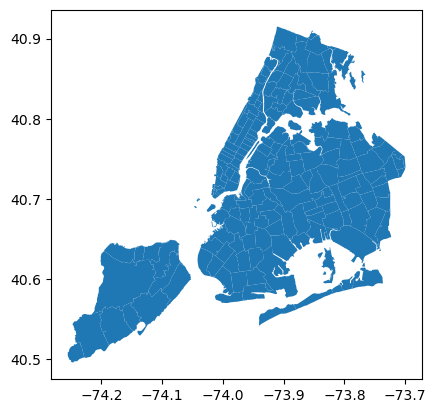

In [10]:
# Using the function
zipcode_datafile = ZIPCODE_DATA_FILE
cleaned_gdf = load_and_clean_zipcodes(zipcode_datafile)
print(cleaned_gdf.head())
cleaned_gdf.plot()

## Complaints Data

### `clean_and_save_311_file`
Cleans and saves a single 311 dataset GeoJSON file. Steps include file validation, data loading, column normalization, spatial join with NYC zip codes, and saving the cleaned data.

### `load_and_clean_311_data`
Processes a list of 311 data files using `clean_and_save_311_file`, streamlining the cleaning and saving process for multiple files.

In [11]:
def clean_and_save_311_file(file_path, output_directory):
    """
    Clean a single GeoJSON file and save the cleaned data to the specified output directory.

    :param file_path: File path of the GeoJSON file to clean.
    :param output_directory: Directory to save the cleaned GeoJSON files.
    """
    # Construct the output file path
    output_file_path = os.path.join(output_directory, os.path.basename(file_path))

    # Check if the output file already exists
    if os.path.exists(output_file_path):
        logging.warning(f"Output file already exists: {output_file_path}")
        return

    # Check if the file exists
    if not os.path.exists(file_path):
        logging.error(f"File does not exist: {file_path}")
        return

    # Log the processing of the file
    logging.info(f"Processing file: {file_path}")

    # Create the output directory if it does not exist
    Path(output_directory).mkdir(parents=True, exist_ok=True)

    # Load the GeoJSON file
    gdf = gpd.read_file(file_path)

    # Perform cleaning operations
    # Load and clean NYC zipcode data
    nyc_zipcodes_gdf = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)

    # Clean and preprocess 311 data
    columns_needed = ['unique_key', 'created_date', 'complaint_type', 'incident_zip', 'geometry']
    gdf = gdf[columns_needed]

    # Remove duplicates
    gdf.drop_duplicates(inplace=True)

    # Rename column 'incident_zip' to 'zipcode'
    gdf.rename(columns={'incident_zip': 'zipcode'}, inplace=True)

    # Normalize column names & column types
    gdf.columns = [col.lower().replace(' ', '_') for col in gdf.columns]
    gdf['unique_key'] = gdf['unique_key'].astype(str)
    gdf['created_date'] = pd.to_datetime(gdf['created_date'], errors='coerce').dropna()
    gdf['zipcode'] = gdf['zipcode'].astype(str)

    # Normalize the Spatial Reference Identifier (SRID) of the geometry
    gdf.set_crs(epsg=4326, inplace=True)

    # Ensure the 'zipcode' column in both dataframes is of the same type
    gdf['zipcode'] = gdf['zipcode'].astype(str)
    nyc_zipcodes_gdf['zipcode'] = nyc_zipcodes_gdf['zipcode'].astype(str)

    # Keep only data points whose zipcode exists in NYC zipcode dataframe
    gdf = gdf[gdf['zipcode'].isin(nyc_zipcodes_gdf['zipcode'])]
    gdf = gpd.sjoin(gdf, nyc_zipcodes_gdf, how='inner', predicate='intersects')
    
    # Merge 'zipcode_left' and 'zipcode_right' columns into a single 'zipcode' column
    gdf['zipcode'] = gdf['zipcode_left'].fillna(gdf['zipcode_right']).astype(str)
    
    # Drop the 'zipcode_left' and 'zipcode_right' columns
    gdf.drop(['zipcode_left', 'zipcode_right'], axis=1, inplace=True)
    
    # Drop the 'index_right' column
    gdf.drop(['index_right'], axis=1, inplace=True)

    # Save the cleaned GeoDataFrame as a new GeoJSON file
    gdf.to_file(output_file_path, driver='GeoJSON')

    # Log completion message
    logging.info(f"File processed and saved to: {output_file_path}")


In [12]:
def load_and_clean_311_data(file_list, output_directory):
    """
    Process each file in the file list: clean and save to the specified output directory.

    :param file_list: List of file paths of GeoJSON files to process.
    :param output_directory: Directory to save the cleaned GeoJSON files.
    """
    for file_path in file_list:
        clean_and_save_311_file(file_path, output_directory)


In [13]:
load_and_clean_311_data(file_list_311, 'data/cleaned_resource')

## Tree Data

### `clean_and_save_tree_data`
Cleans a single tree data file by removing non-NYC entries, duplicate tree IDs, and saves the cleaned data. Involves file verification, data loading, necessary column filtering, spatial join with NYC zip codes, duplicate removal, and saving the cleaned data.

### `load_and_clean_tree_data`
Processes multiple tree data files, applying `clean_and_save_tree_data` to each file for efficient batch cleaning and saving.

In [14]:
def clean_and_save_tree_data(file_path, output_directory):
    """
    Clean a single tree data file, remove entries not in NYC, remove duplicate tree_ids, and save the cleaned data to the specified output directory.

    :param file_path: File path of the tree data file to clean.
    :param output_directory: Directory to save the cleaned tree data files.
    """
    # Construct the output file path
    output_file_path = os.path.join(output_directory, os.path.basename(file_path))

    # Check if the output file already exists
    if os.path.exists(output_file_path):
        logging.warning(f"Output file already exists: {output_file_path}")
        return

    # Check if the file exists
    if not os.path.exists(file_path):
        logging.error(f"File does not exist: {file_path}")
        return

    # Log the processing of the file
    logging.info(f"Processing file: {file_path}")

    # Create the output directory if it does not exist
    Path(output_directory).mkdir(parents=True, exist_ok=True)

    # Load the tree data file
    gdf = gpd.read_file(file_path)

    # Perform cleaning operations
    columns_needed = ['tree_id', 'zipcode', 'spc_common', 'health', 'status', 'geometry']
    gdf = gdf[columns_needed]

    # Removing invalid data points
    gdf.dropna(subset=['zipcode', 'health', 'status'], inplace=True)

    # Rename 'spc_common' column to 'species'
    gdf.rename(columns={'spc_common': 'species'}, inplace=True)

    # Normalize column names & column types
    gdf.columns = [col.lower().replace(' ', '_') for col in gdf.columns]
    gdf['tree_id'] = gdf['tree_id'].astype(str)
    gdf['zipcode'] = gdf['zipcode'].astype(str)

    # Normalize the Spatial Reference Identifier (SRID) of the geometry
    gdf.set_crs(epsg=4326, inplace=True)

    # Load and clean NYC zipcode data
    nyc_zipcodes_gdf = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)

    # Filter out data points not in NYC
    gdf = gdf[gdf['zipcode'].isin(nyc_zipcodes_gdf['zipcode'])]
    gdf = gpd.sjoin(gdf, nyc_zipcodes_gdf, how='inner', predicate='intersects')
    
    # Merge 'zipcode_left' and 'zipcode_right' columns into a single 'zipcode' column
    gdf['zipcode'] = gdf['zipcode_left'].fillna(gdf['zipcode_right']).astype(str)
    
    # Drop the 'zipcode_left' and 'zipcode_right' columns
    gdf.drop(['zipcode_left', 'zipcode_right'], axis=1, inplace=True)
    
    # Drop the 'index_right' column
    gdf.drop(['index_right'], axis=1, inplace=True)
    
    # Remove duplicates based on tree_id
    gdf.drop_duplicates(subset=['tree_id'], inplace=True)

    # Save the cleaned GeoDataFrame as a new file
    gdf.to_file(output_file_path, driver='GeoJSON')

    # Log completion message
    logging.info(f"File processed and saved to: {output_file_path}")

In [15]:
def load_and_clean_tree_data(file_list, output_directory):
    """
    Process each file in the file list: clean and save to the specified output directory.

    :param file_list: List of file paths of GeoJSON files to process.
    :param output_directory: Directory to save the cleaned GeoJSON files.
    """
    for file_path in file_list:
        clean_and_save_tree_data(file_path, output_directory)


In [16]:
output_directory = 'data/cleaned_resource'
load_and_clean_tree_data(file_list_2015, output_directory)

## Zillow Data

This function is designed to load and clean Zillow rent data, specifically focusing on New York City zip codes. 

In [1]:
def load_and_clean_zillow_data(zillow_datafile):
    """
    Load and clean Zillow rent data, filter for NYC zip codes.

    Args:
        zillow_datafile (str): Path to the Zillow rent data CSV file.

    Returns:
        df (pd.DataFrame): Cleaned and filtered DataFrame containing Zillow rent data for NYC.
    """
    # Load Zillow rent data into a DataFrame
    df = pd.read_csv(zillow_datafile)
    
    # Filter to keep only NYC zip codes
    nyc_zipcodes_gdf = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
    nyc_zipcodes_gdf['zipcode'] = nyc_zipcodes_gdf['zipcode'].astype(str)
    df['RegionName'] = df['RegionName'].astype(str)
    df = df[df['RegionName'].isin(nyc_zipcodes_gdf['zipcode'].astype(str))]

    # Define columns needed (RegionName and dates columns)
    columns_needed = ['RegionName'] + list(df.columns[10:])  # Select columns from 2015/1/31 onwards

    # Keep only the necessary columns
    df = df[columns_needed]

    # Rename 'RegionName' to 'zipcode'
    df.rename(columns={'RegionName': 'zipcode'}, inplace=True)

    # Normalize column names to lowercase
    df.columns = [col.lower() for col in df.columns]

    # Melt the DataFrame to have a structured format (Date, Zipcode, Value)
    df = df.melt(id_vars=['zipcode'], var_name='date', value_name='value')

    # Convert the 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    
    # Remove rows where 'value' is missing
    df = df.dropna(subset=['value'])

    # Reset the index
    df.reset_index(drop=True, inplace=True)
    
    return df


In [ ]:
zillow_datafile = ZILLOW_DATA_FILE
cleaned_df_zillow = load_and_clean_zillow_data(zillow_datafile)
print(cleaned_df_zillow.head())

## Data Loading and Preprocessing

In [ ]:
# Function to load all required data for the project.
def load_all_data():
    """
    This function loads and cleans various datasets required for the project.

    It loads zip code data, tree data, 311 data, and Zillow data.

    Returns:
    tuple: A tuple containing four dataframes -
           (geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data)
    """
    logger.info("Starting to load data...")

    # Load and clean zip code data
    geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
    logger.info("Zip code data loaded successfully.")

    # Load and merge tree data
    geodf_tree_data_list = []
    for j in range(7):
        try:
            file_path = f"data/cleaned_resource/5rq2-4hqu.geojson_{j}.geojson"
            geodf_tree_data = gpd.read_file(file_path)
            geodf_tree_data_list.append(geodf_tree_data)
            logger.info(f"File loaded: {file_path}")
        except Exception as e:
            logger.error(f"Error reading file {file_path}: {e}")

    geodf_tree_data_j = pd.concat(geodf_tree_data_list, ignore_index=True)
    logger.info("Tree data loaded and merged successfully.")

    # Load and merge 311 data
    geodf_311_data_list = []
    for i in range(250):
        try:
            file_path = f"data/cleaned_resource/erm2-nwe9.geojson_{i}.geojson"
            geodf_311_data = gpd.read_file(file_path)
            geodf_311_data_list.append(geodf_311_data)
            logger.info(f"File loaded: {file_path}")
        except Exception as e:
            logger.error(f"Error reading file {file_path}: {e}")

    geodf_311_data_i = pd.concat(geodf_311_data_list, ignore_index=True)
    logger.info("311 data loaded and merged successfully.")

    # Load and clean Zillow data
    df_zillow_data = load_and_clean_zillow_data(ZILLOW_DATA_FILE)
    logger.info("Zillow data loaded successfully.")

    return (
        geodf_zipcode_data,
        geodf_311_data_i,
        geodf_tree_data_j,
        df_zillow_data
    )


In [ ]:
# Load and preprocess all required data for the project
geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

## Display DataFrame Information and First 5 Entries

In this code block, we intend to provide an overview of the data in different DataFrames. The code uses the `info()` method to display basic information about each DataFrame, including the data types and non-null counts of columns. Additionally, the `head()` method is used to display the first 5 entries (rows) of each DataFrame, giving a glimpse of the actual data.

In [ ]:
# Show basic info about each dataframe
geodf_zipcode_data.info()

In [ ]:
# Show first 5 entries about each dataframe
geodf_zipcode_data.head()

In [ ]:
geodf_311_data.info()

In [ ]:
geodf_311_data.head()

In [ ]:
geodf_tree_data.info()

In [ ]:
geodf_tree_data.head()

In [ ]:
df_zillow_data.info()

In [ ]:
df_zillow_data.head()